In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.collections import PolyCollection

# Render plots as SVG
%config InlineBackend.figure_format = 'svg'

In [2]:
meta = pd.read_excel('data/metadata.xlsx')
meta.sample(5)

,File name,Author,Title,Publication date,Series + n°,Editor,Illustrator,Publisher,Place of publication,Intended reader,Source intended reader,Date of debut,Author's birth date,Author's age at time of publication,Author's gender,Country,Comments,English title
504,SAX_mistoverhetstrand_2001,Aline Sax,Mist over het strand,2001,NaN,NaN,NaN,Clavis,Amsterdam,12,website author,2001,1984,17,F,VL,CBK: 15,NaN
236,FRANCK_metdekonttegendekrib_1989,Ed Franck,Met de kont tegen de krib,1989,NaN,NaN,Gerda Dendooven,Clavis,Hasselt,9,CBK,1985,1941,48,M,VL,NaN,NaN
738,WOLTZ_hetgeheimvandestoereprinses_2007,Anna Woltz,Het geheim van de stoere prinses,2007,NaN,NaN,Saskia Halfmouw,Leopold,Amsterdam,8,website author,1998,1981,26,F,NL,co-auteur: Roos van den Berg,NaN
710,WILSON_themonsterstoryteller_1997,Jacqueline Wilson,The Monster Story-Teller,1997,NaN,NaN,Nick Sharratt,Doubleday,London,5,website author,1969,1945,52,F,UK,NaN,NaN
116,COTTRELL-BOYCE_theunforgottencoat_2011,Frank Cottrell-Boyce,The Unforgotten Coat,2011,NaN,NaN,NaN,Walker Books,London,9,website publisher,2004,1959,52,M,UK,NaN,NaN


In [3]:
meta.shape

(753, 18)

In [4]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   File name                            753 non-null    object
 1   Author                               753 non-null    object
 2   Title                                753 non-null    object
 3   Publication date                     753 non-null    int64 
 4   Series  + n°                         167 non-null    object
 5   Editor                               1 non-null      object
 6   Illustrator                          410 non-null    object
 7   Publisher                            741 non-null    object
 8   Place of publication                 739 non-null    object
 9   Intended reader                      753 non-null    object
 10  Source intended reader               643 non-null    object
 11  Date of debut                        753 non-

In [5]:
memory_before = meta.memory_usage(deep=True).sum() / 1024
f'{memory_before:.2f} KB'

'596.49 KB'

## Cleaning up the dataset

(following [Matt Harrison's](https://twitter.com/__mharrison__) 'chaining' approach to Pandas)

In [6]:
meta = (
    meta
    .rename(lambda col: col.replace(' ', '_').lower(), axis=1)
    .rename(columns={'publication_date': 'pub_year', "author's_age_at_time_of_publication": 'author_age_pub', "author's_gender": 'author_gender'})
    .loc[:, ['file_name', 'author', 'title', 'pub_year', 'intended_reader', 'author_age_pub', 'author_gender', 'country']]
    .dropna(axis=0, how='any')
    .query(
        "country == 'UK' & \
        intended_reader != '-' & \
        author.str.contains('/') == False"
    )
    .astype({
        'author': 'category',
        'intended_reader': int,
        'author_gender': 'category'
    })
)

pd.to_datetime(meta['pub_year'], format='%Y')
meta.sample(10)

,file_name,author,title,pub_year,intended_reader,author_age_pub,author_gender,country
683,WILSON_mysisterjodie_2008,Jacqueline Wilson,My Sister Jodie,2008,12,63,F,UK
170,FINE_rolloverroly_1999,Anne Fine,Roll Over Roly,1999,7,52,F,UK
686,WILSON_queenie_2013,Jacqueline Wilson,Queenie,2013,9,68,F,UK
146,FINE_fridaysurprise_2010,Anne Fine,Friday Surprise,2010,7,63,F,UK
171,FINE_roundbehindtheicehouse_1981,Anne Fine,Round Behind the Ice-House,1981,12,34,F,UK
63,BLACKMAN_myfriendsagrisquok_1994,Malorie Blackman,My Friend's a Gris-Quok,1994,7,32,F,UK
37,BLACKMAN_betseysbirthdaysurprise_1996,Malorie Blackman,Betsey's Birthday Surprise,1996,5,34,F,UK
49,BLACKMAN_fangs_1998,Malorie Blackman,Fangs,1998,5,36,F,UK
38,BLACKMAN_boysdontcry_2010,Malorie Blackman,Boys Don't Cry,2010,12,48,F,UK
161,FINE_loudmouthlouis_1998,Anne Fine,Loudmouth Louis,1998,7,51,F,UK


In [7]:
meta = (meta
    .assign(reader_age_group=np.where(meta['intended_reader'] == 18, 'adult' , 'child'))
    .astype({'reader_age_group': 'category'})
    .drop(['country', 'intended_reader'], axis=1)
)

In [8]:
meta.shape

(327, 7)

In [9]:
memory_after = meta.memory_usage(deep=True).sum() / 1024
print(f"{memory_after:.2f} KB")

61.35 KB


In [10]:
# memory difference
print(f"{abs(memory_after - memory_before):.2f} KB")

535.15 KB


In [11]:
meta.to_csv('data/metadata_en_baseline_sample.csv', index=False, encoding='utf-8')

### Remove authors who have published only for adults or children

In [12]:
meta.groupby('reader_age_group')['author'].value_counts(sort=False)

reader_age_group                      
adult             Aidan Chambers           0
                  Anne Fine                9
                  David Almond             2
                  Frank Cottrell-Boyce     0
                  J.K. Rowling             6
                  Jacqueline Wilson        0
                  Jamila Gavin             0
                  Jill Murphy              0
                  Malorie Blackman         0
                  Neil Gaiman              6
                  Philip Pullman           3
child             Aidan Chambers          11
                  Anne Fine               74
                  David Almond            22
                  Frank Cottrell-Boyce    13
                  J.K. Rowling             8
                  Jacqueline Wilson       69
                  Jamila Gavin            13
                  Jill Murphy             10
                  Malorie Blackman        50
                  Neil Gaiman              8
                

In the output above, we see that all authors have published books for children. We therefore need to filter out those who haven't published for adults.

In [13]:
df = (meta
    .groupby('author')
    .filter(lambda _df: _df['reader_age_group'].nunique() == 2)
)

print("Before:", meta['reader_age_group'].value_counts(sort=False), sep='\n', end='\n\n')
print("After: ", df['reader_age_group'].value_counts(sort=False), sep='\n')

Before:
adult     26
child    301
Name: reader_age_group, dtype: int64

After: 
adult     26
child    135
Name: reader_age_group, dtype: int64


In [14]:
(df
    .groupby('author', observed=True)['reader_age_group']  # `observed=True`: Hide authors with 0 observations
    .value_counts(dropna=True)
)

author               
David Almond    child    22
                adult     2
Anne Fine       child    74
                adult     9
Neil Gaiman     child     8
                adult     6
Philip Pullman  child    23
                adult     3
J.K. Rowling    child     8
                adult     6
Name: reader_age_group, dtype: int64

In [15]:
print(df.shape)

df.to_csv('data/metadata_en_final_sample.csv', index=False, encoding='utf-8')

(161, 7)


## Descriptive statistics

### Get the number of books per reader group for each of the authors

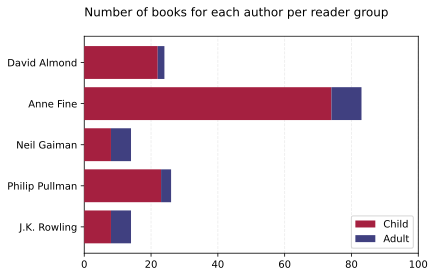

In [16]:
temp_df = df[['author', 'reader_age_group']]

ages_per_author = (
    list(
        reversed(temp_df
            .groupby('author', observed=True)['reader_age_group']
            .value_counts()
            .tolist()
        )  # reverse order to match alphabetical order below
    )
)

x = list(set(temp_df['author'].values.tolist()))
x = sorted(x, key=lambda fullname: fullname.split(' ')[-1], reverse=True) # Reverse on reverse!

y1 = np.array(
    [ages_per_author[i] 
        for i in range(1, len(ages_per_author), len(temp_df.columns))]
)

y2 = np.array(
    [ages_per_author[i] 
        for i in range(0, len(ages_per_author), len(temp_df.columns))]
)

colors = sns.color_palette('gist_stern', 7)

plt.barh(x, y1, color=colors[0], zorder=5)
plt.barh(x, y2, left=y1, color=colors[1], zorder=5)

plt.title("Number of books for each author per reader group", loc='left', pad=20)
plt.xlim(0, 100)
plt.grid(True, axis='x', alpha=.25, linestyle='--', zorder=1)
plt.legend(['Child', 'Adult'], loc='lower right');

### Authors' gender per reader group

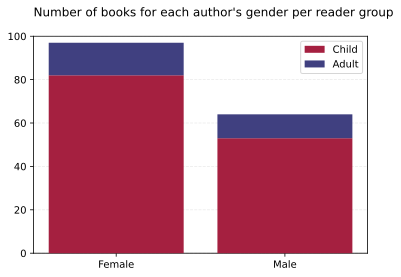

In [17]:
temp_df = df[['author_gender', 'reader_age_group']]

author_genders = (
    list(
        reversed(temp_df
            .groupby('author_gender', observed=True)['reader_age_group']
            .value_counts()
            .tolist()
        )
    )
)

x = sorted(list(set(temp_df['author_gender'].values.tolist())))

y1 = np.array(
    [author_genders[i]
        for i in range(1, len(author_genders), len(temp_df.columns))]
)

y2 = np.array(
    [author_genders[i] 
        for i in range(0, len(author_genders), len(temp_df.columns))]
)

colors = sns.color_palette('gist_stern', 7)

plt.bar(x, y1, color=colors[0], zorder=5)
plt.bar(x, y2, bottom=y1, color=colors[1], zorder=5)

plt.title("Number of books for each author's gender per reader group", loc='left', pad=20)
plt.ylim(0, 100)
plt.xticks([0, 1], labels=['Female', 'Male'])
plt.grid(True, axis='y', alpha=.25, linestyle='--', zorder=1)
plt.legend(['Child', 'Adult'], loc='upper right');

### When did each author start writing for each reader group?

In [18]:
temp_df = df[['author', 'pub_year', 'reader_age_group']]

started = (temp_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .min()
)

ended = (temp_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .max()
)

period = pd.DataFrame({'earliest_pub': started, 'latest_pub': ended})
period

earliest_pub  latest_pub
author         reader_age_group                          
David Almond   child                     1998        2021
               adult                     2011        2014
Anne Fine      child                     1978        2019
               adult                     1986        2016
Neil Gaiman    child                     1999        2013
               adult                     1996        2015
Philip Pullman child                     1982        2020
               adult                     1972        2010
J.K. Rowling   child                     1997        2020
               adult                     2012        2020

In [19]:
earliest_year = period['earliest_pub'].min()
latest_year = period['latest_pub'].max()

earliest_year, latest_year

(1972, 2021)

In [20]:
time_df = df[['author', 'pub_year', 'reader_age_group']]

years = pd.date_range(
    start=f'01/01/{earliest_year}',
    end=f'01/01/{latest_year + 1}',
    freq='Y'
)

years_list = list(years.year.values)

time_df = (
    pd.concat([
        time_df,
        pd.DataFrame(
            np.NaN,
            columns=years_list,
            index=time_df.index
        )
    ],
    axis=1)
)

time_df['Counts'] = (time_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .cumcount()
    .add(1)
)

works_df = (time_df
    .groupby(['author', 'reader_age_group'], observed=True)['pub_year']
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
)

works_df

pub_year                         1972  1978  1979  1980  1981  1982  1983  \
author         reader_age_group                                             
David Almond   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Anne Fine      child                0     1     1     1     1     0     1   
               adult                0     0     0     0     0     0     0   
Neil Gaiman    child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Philip Pullman child                0     0     0     0     0     1     0   
               adult                1     1     0     0     0     0     0   
J.K. Rowling   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   

pub_year                         1985  1986  1987  ...  2012  2013  2014  \
author         reader_age_group                    ...                     
David Almond   child                0     0     0  ...     1     0     1   
               adult                0     0     0  ...     0     0     1   
Anne Fine      child                1     1     1  ...     1     5     2   
               adult                0     1     0  ...     0     0     0   
Neil Gaiman    child                0     0     0  ...     0     2     0   
               adult                0     0     0  ...     0     1     1   
Philip Pullman child                1     1     0  ...     0     0     1   
               adult                0     0     0  ...     0     0     0   
J.K. Rowling   child                0     0     0  ...     0     0     0   
               adult                0     0     0  ...     1     1     1   

pub_year                         2015  2016  2017  2018  2019  2020  2021  
author         reader_age_group                                            
David Almond   child                1     0     1     2     0     2     1  
               adult                0     0     0     0     0     0     0  
Anne Fine      child                3     0     2     1     1     0     0  
               adult                0     1     0     0     0     0     0  
Neil Gaiman    child                0     0     0     0     0     0     0  
               adult                1     0     0     0     0     0     0  
Philip Pullman child                0     0     1     0     1     1     0  
               adult                0     0     0     0     0     0     0  
J.K. Rowling   child                0     0     0     0     0     1     0  
               adult                1     0     0     1     0     1     0  

[10 rows x 43 columns]

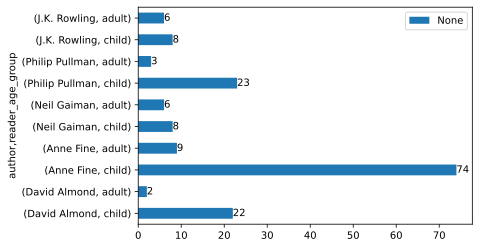

In [21]:
# Just to crosscheck with above df
ax = works_df.sum(axis=1).plot(kind='barh', legend=True)
ax.bar_label(ax.containers[0]);

In [22]:
test_df = works_df.transpose()

In [23]:
tidy_df = test_df.transpose()
tidy_df

pub_year                         1972  1978  1979  1980  1981  1982  1983  \
author         reader_age_group                                             
David Almond   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Anne Fine      child                0     1     1     1     1     0     1   
               adult                0     0     0     0     0     0     0   
Neil Gaiman    child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   
Philip Pullman child                0     0     0     0     0     1     0   
               adult                1     1     0     0     0     0     0   
J.K. Rowling   child                0     0     0     0     0     0     0   
               adult                0     0     0     0     0     0     0   

pub_year                         1985  1986  1987  ...  2012  2013  2014  \
author         reader_age_group                    ...                     
David Almond   child                0     0     0  ...     1     0     1   
               adult                0     0     0  ...     0     0     1   
Anne Fine      child                1     1     1  ...     1     5     2   
               adult                0     1     0  ...     0     0     0   
Neil Gaiman    child                0     0     0  ...     0     2     0   
               adult                0     0     0  ...     0     1     1   
Philip Pullman child                1     1     0  ...     0     0     1   
               adult                0     0     0  ...     0     0     0   
J.K. Rowling   child                0     0     0  ...     0     0     0   
               adult                0     0     0  ...     1     1     1   

pub_year                         2015  2016  2017  2018  2019  2020  2021  
author         reader_age_group                                            
David Almond   child                1     0     1     2     0     2     1  
               adult                0     0     0     0     0     0     0  
Anne Fine      child                3     0     2     1     1     0     0  
               adult                0     1     0     0     0     0     0  
Neil Gaiman    child                0     0     0     0     0     0     0  
               adult                1     0     0     0     0     0     0  
Philip Pullman child                0     0     1     0     1     1     0  
               adult                0     0     0     0     0     0     0  
J.K. Rowling   child                0     0     0     0     0     1     0  
               adult                1     0     0     1     0     1     0  

[10 rows x 43 columns]

In [24]:
tidy_df = (
    pd.melt(
        works_df.reset_index(),
        id_vars=('author', 'reader_age_group'),
        var_name='pub_year',
        value_name='count'
    )
)

print("Before:", tidy_df.shape)

tidy_df = (
    tidy_df[tidy_df['count'] > 0]
    .astype({'count': int})
)

print("After:", tidy_df.shape)

tidy_df['pub_year'] = pd.to_datetime(tidy_df['pub_year'], format='%Y').dt.year
tidy_df

Before: (430, 4)
After: (113, 4)


,author,reader_age_group,pub_year,count
7,Philip Pullman,adult,1972,1
12,Anne Fine,child,1978,1
17,Philip Pullman,adult,1978,1
22,Anne Fine,child,1979,1
32,Anne Fine,child,1980,1
...,...,...,...,...
410,David Almond,child,2020,2
416,Philip Pullman,child,2020,1
418,J.K. Rowling,child,2020,1
419,J.K. Rowling,adult,2020,1


In [25]:
simple_df = tidy_df.copy()

simple_df['pub_year_start'] = (
    pd.to_datetime(
        simple_df['pub_year'],
        format='%Y'
    )
    .dt.strftime('%Y-%m-%d')
)

simple_df['pub_year_end'] = (
    pd.to_datetime(simple_df['pub_year_start'], format='%Y-%m-%d')
    + pd.DateOffset(months=11, days=30)
)
simple_df.head()

,author,reader_age_group,pub_year,count,pub_year_start,pub_year_end
7,Philip Pullman,adult,1972,1,1972-01-01,1972-12-31
12,Anne Fine,child,1978,1,1978-01-01,1978-12-31
17,Philip Pullman,adult,1978,1,1978-01-01,1978-12-31
22,Anne Fine,child,1979,1,1979-01-01,1979-12-31
32,Anne Fine,child,1980,1,1980-01-01,1980-12-31


In [26]:
authors = [author for author in simple_df['author'].unique()]

author_1_df = simple_df[simple_df['author'] == authors[0]]
author_2_df = simple_df[simple_df['author'] == authors[1]]
author_3_df = simple_df[simple_df['author'] == authors[2]]
author_4_df = simple_df[simple_df['author'] == authors[3]]
author_5_df = simple_df[simple_df['author'] == authors[4]]

# Constants
CATEGORIES = {
    "child": 1,
    "adult": 2
}

CMAPS = {
    "child": "#a52040",
    "adult": "#404080"
}

START_YEAR = mdates.datestr2num(str(min(years_list) - 2))
END_YEAR = mdates.datestr2num(str(max(years_list) + 2))
TITLE_PAD = 16
Y_LABELS = ["Child", "Adult"]

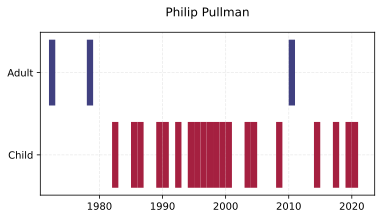

In [27]:
author_1 = author_1_df['author'].unique()[0]
data_1 = (author_1_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_1.keys()):
    if data_1[k] == 0:
        del data_1[k]

verts = []
colors = []

for d in data_1:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_1, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

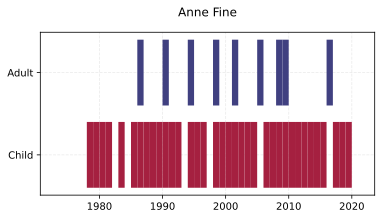

In [28]:
author_2 = author_2_df['author'].unique()[0]
data_2 = (author_2_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_2.keys()):
    if data_2[k] == 0:
        del data_2[k]

verts = []
colors = []

for d in data_2:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_2, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

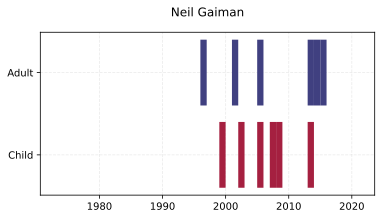

In [29]:
author_3 = author_3_df['author'].unique()[0]
data_3 = (author_3_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_3.keys()):
    if data_3[k] == 0:
        del data_3[k]

verts = []
colors = []

for d in data_3:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_3, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

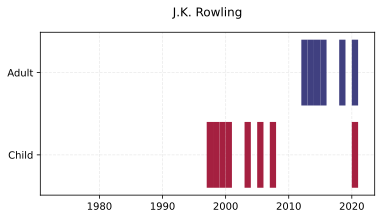

In [30]:
author_4 = author_4_df['author'].unique()[0]
data_4 = (author_4_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_4.keys()):
    if data_4[k] == 0:
        del data_4[k]

verts = []
colors = []

for d in data_4:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_4, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

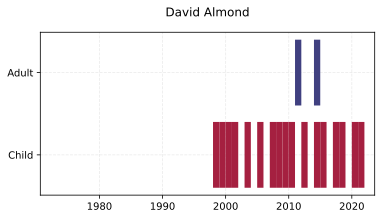

In [31]:
author_5 = author_5_df['author'].unique()[0]
data_5 = (author_5_df
    .groupby(['reader_age_group', 'pub_year_start', 'pub_year_end'])['count']
    .sum()
    .to_dict()
)

for k in list(data_5.keys()):
    if data_5[k] == 0:
        del data_5[k]

verts = []
colors = []

for d in data_5:
    i = [
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]+.4),
        (mdates.datestr2num(str(d[1])), CATEGORIES[d[0]]-.4),
        (mdates.datestr2num(str(d[2])), CATEGORIES[d[0]]-.4)
    ]
    verts.append(i)
    colors.append(CMAPS[d[0]])

bars = PolyCollection(verts, facecolors=colors, zorder=2)

fig, ax = plt.subplots(figsize=(6, 3))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.AutoDateLocator(interval_multiples=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_title(author_5, pad=TITLE_PAD)
ax.set_yticks([1, 2], Y_LABELS)
ax.grid(True, which='both', axis='both', linestyle='--', alpha=.25, zorder=1)
ax.set_xlim(START_YEAR, END_YEAR)
plt.show()

## Load corpus from directory

In [32]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [33]:
df = pd.read_csv('data/metadata_en_final_sample.csv', encoding='utf-8')

print(df.shape)
df.sample(5)

(161, 7)


,file_name,author,title,pub_year,author_age_pub,author_gender,reader_age_group
86,FINE_thekillercatrunsaway_2013,Anne Fine,The Killer Cat Runs Away,2013,66,F,child
129,PULLMAN_onceuponatimeinthenorth_2008,Philip Pullman,Once Upon a Time in the North,2008,62,M,child
118,GAIMAN_theoceanattheendofthelane_2013,Neil Gaiman,The Ocean at the End of the Lane,2013,53,M,adult
27,FINE_asuddenglowofgold_1991,Anne Fine,A Sudden Glow of Gold,1991,44,F,child
68,FINE_roundbehindtheicehouse_1981,Anne Fine,Round Behind the Ice-House,1981,34,F,child


In [34]:
included_authors = df['author'].unique()

included_authors_surnames = sorted(
    [included_authors[i].split(' ')[-1].upper()
        for i, _ in enumerate(included_authors)]
)

included_authors_surnames

['ALMOND', 'FINE', 'GAIMAN', 'PULLMAN', 'ROWLING']

In [35]:
def load_directory(
    directory: str, 
    *, 
    file_type: str = 'txt', 
    max_length: int = 0,
    authors_list: list = None
) -> list:
    filenames, texts, authors, titles = [], [], [], []
    for file in glob.glob(os.path.join(directory, f'*.{file_type}')):
        filename, _ = os.path.splitext(os.path.basename(file))
        author = filename.split('_')[0]

        # Only include authors in the list, if provided
        if authors_list is not None:
            if author.upper() not in set(authors_list):
                continue

        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            contents = f.read()
        lemmas = contents.lower().split()
        start_idx, end_idx, segm = 0, max_length, 1

        while end_idx < len(lemmas):
            texts.append(" ".join(lemmas[start_idx:end_idx]))
            authors.append(author)
            title = filename.replace('.txt', '').split('_')[1]
            titles.append(f"{title}-{segm}")
            # filename = f"{author}_{title}_{segm}"
            filenames.append(filename.removesuffix('.txt'))

            start_idx += max_length
            end_idx += max_length
            segm += 1

    return filenames, texts, authors, titles

### But first...

Before loading the corpus, we need to see what the optimal value for `max_len` is, to include as many texts from each author as possible.

Since we are not going to be comparing the authors against each other &ndash;but, rather, how they write for the two different age groups of their readers&ndash; we are not affected by the amount of some authors being over or under-represented in the corpus.

In [36]:
from typing import Dict

def count_words_in_dir(
    directory: str = os.getcwd(), 
    *, 
    file_type: str = 'txt', 
    authors_list: list = None
) -> Dict[str, int]:

    word_counts = {}

    for file in glob.glob(os.path.join(directory, f'*.{file_type}')):
        filename, _ = os.path.splitext(os.path.basename(file))
        author = filename.split('_')[0]

        # Only include authors in the list, if provided
        if authors_list is not None:
            if author.upper() not in set(authors_list):
                continue

        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            contents = f.read()
        words = contents.split()
        filename = filename.removesuffix('.txt')
        
        word_counts[filename] = len(words)
    
    return word_counts

In [37]:
from pprint import pprint 

wc = count_words_in_dir('data/books_en/', authors_list=included_authors_surnames)

wc_df = pd.DataFrame.from_dict(wc, orient='index', columns=['word_count'])

wc_df.sample(5)

,word_count
FINE_talesfromweirdstreet_2017,5469
FINE_thesummerhouseloon_1978,27033
FINE_thekillercatrunsaway_2013,10136
PULLMAN_therubyinthesmoke_1985,59542
ALMOND_thetruetaleofthemonsterbillydean_2011,69402


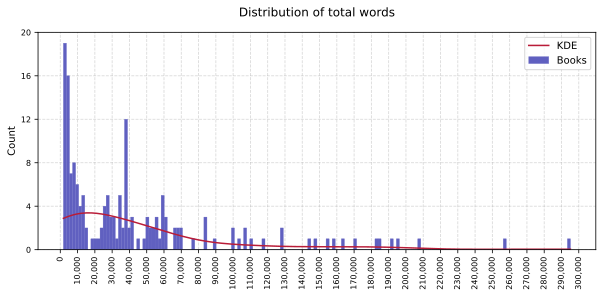

In [38]:
wc = wc_df['word_count']
bins = len(wc)
step = 10_000
x_ticks = np.arange(0, max(wc) + step, step)
palette = list(sns.color_palette('gist_stern', 8).as_hex())

fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(
    wc_df, x=wc,
    bins=bins, ax=ax, kde=True,
    palette=palette[:len(included_authors_surnames)], # remove the aweful yellow colors
    zorder=2
)

ax.lines[0].set_color(palette[0])

# A hacky way to change the color of the bins
for i in range(bins):
    ax.patches[i].set_facecolor('#6060c0')
    ax.patches[i].set_edgecolor('#6060c0')

# Format thousands separator in x-axis labels
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda tick, pos: format(int(tick), ','))
)

plt.title("Distribution of total words", pad=TITLE_PAD)
plt.ylabel("Count")
plt.yticks(np.arange(0, 21, 4), size=8)
plt.xlabel(None)
plt.xticks(x_ticks, size=8, rotation=90)
plt.legend(['KDE', 'Books'])
plt.grid(axis='both', linestyle='--', alpha=0.5, zorder=0);

### Loading the corpus (actually this time)

In [39]:
filenames, texts, authors, titles = load_directory('data/books_en', max_length=1000, authors_list=included_authors_surnames)

print(len(filenames), len(texts), len(authors), len(titles))

7250 7250 7250 7250


In [40]:
print(set(authors))

{'PULLMAN', 'ROWLING', 'ALMOND', 'FINE', 'GAIMAN'}


In [41]:
# Check for missing files
# Option 1
print(len(set(filenames)) == len(set(wc_df.index)))

# Option 2
missing = len(set(wc_df.index.tolist()).difference(filenames))
print(f"{missing} missing files")

True
0 missing files


In [42]:
docs = (pd
    .DataFrame({
        'text': texts,
        'author': authors, 
        'file_name': filenames, 
        'segment': titles
    })
)
docs.sample(10)

,text,author,file_name,segment
5373,"before. more shops than ever were boarded-up, ...",ROWLING,ROWLING_harrypotterandthedeathlyhallows_2007,harrypotterandthedeathlyhallows-135
1284,worried me. i knew the streets could only get ...,FINE,FINE_flyintheointment_2008,flyintheointment-57
1467,chapter one a quiet afternoon tea with father ...,FINE,FINE_madamedoubtfire_1987,madamedoubtfire-1
3051,where they had drunk islington’s wine: an octa...,GAIMAN,GAIMAN_neverwhere_1996,neverwhere-86
399,curtain. she spoke in little whispery breaths....,ALMOND,ALMOND_mynameismina_2010,mynameismina-28
23,the sea turned and splashed behind us. ‘he’s n...,ALMOND,ALMOND_asongforellagrey_2014,asongforellagrey-24
1239,"of the world.’ as for myself, sitting there in...",FINE,FINE_flyintheointment_2008,flyintheointment-12
4110,sound came from the audience. then came the mo...,PULLMAN,PULLMAN_thefireworkmakersdaughter_1995,thefireworkmakersdaughter-14
1646,with a soft pop. the ice-house turns cold and ...,FINE,FINE_roundbehindtheicehouse_1981,roundbehindtheicehouse-3
44,"sang her back to newcastle, to the town moor, ...",ALMOND,ALMOND_bonemusic_2021,bonemusic-8


In [43]:
docs['file_name'].nunique()

166

In [44]:
df = (pd.merge(docs, meta, on='file_name'))

df = (df
    .drop('author_x', axis=1)
    .rename(columns={'author_y': 'author'})
)

df.sample(5)

,text,file_name,segment,author,title,pub_year,author_age_pub,author_gender,reader_age_group
3554,"swept across the ever- moving trees outside, i...",PULLMAN_theamberspyglass_2000,theamberspyglass-46,Philip Pullman,The Amber Spyglass,2000,54,M,child
862,"pile they call sticklebury cathedral, and buil...",FINE_apackofliars_1988,apackofliars-9,Anne Fine,A Pack of Liars,1988,41,F,child
5862,"the father whom strike had only met twice, and...",ROWLING_lethalwhite_2018,lethalwhite-10,J.K. Rowling,Lethal White,2018,53,F,adult
5036,"himself, the end would be clean, and the job t...",ROWLING_harrypotterandthedeathlyhallows_2007,harrypotterandthedeathlyhallows-179,J.K. Rowling,Harry Potter and the Deathly Hallows,2007,42,F,child
5785,flitwick closed all doors into the hall. ‘i’m ...,ROWLING_harrypotterandtheprisonerofazkaban_1999,harrypotterandtheprisonerofazkaban-40,J.K. Rowling,Harry Potter and the Prisoner of Azkaban,1999,34,F,child


In [45]:
df.to_csv('data/crosswriters.csv', index=False, encoding='utf-8')